In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import plantcv as pcv
import os

from random import shuffle
from PIL import Image
from tensorflow.contrib import slim
from tensorflow.contrib.slim.python.slim.nets import resnet_v2

import matplotlib
%matplotlib inline

C:\Users\Gio\Documents\tools\miniconda\envs\plantcv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
MODEL_DIR = 'C:/Users/Gio/Documents/projects/resnet50/model'
EVAL_DIR = 'C:/Users/Gio/Documents/projects/resnet50/evaluation'
CLASSES = ['guava', 'akapulko']

In [3]:
def preprocess_image(img):
    device = 0
    debug = False
    device, s = pcv.rgb2gray_hsv(img, 's', device, debug)
    device, s_thresh = pcv.binary_threshold(s, 85, 255, 'light', device, debug)
    device, s_mblur = pcv.median_blur(s_thresh, 5, device, debug)
    device, s_cnt = pcv.median_blur(s_thresh, 5, device, debug)
    device, b = pcv.rgb2gray_lab(img, 'b', device, debug)
    device, b_thresh = pcv.binary_threshold(b, 160, 255, 'light', device, debug)
    device, b_cnt = pcv.binary_threshold(b, 160, 255, 'light', device, debug)
    #device, b_fill = pcv.fill(b_thresh, b_cnt, 10, device, debug)
    device, bs = pcv.logical_or(s_mblur, b_cnt, device, debug)
    device, masked = pcv.apply_mask(img, bs, 'white', device, debug)
    device, masked_a = pcv.rgb2gray_lab(masked, 'a', device, debug)
    device, masked_b = pcv.rgb2gray_lab(masked, 'b', device, debug)
    device, maskeda_thresh = pcv.binary_threshold(masked_a, 115, 255, 'dark', device, debug)
    device, maskeda_thresh1 = pcv.binary_threshold(masked_a, 135, 255, 'light', device, debug)
    device, maskedb_thresh = pcv.binary_threshold(masked_b, 128, 255, 'light', device, debug)
    device, ab1 = pcv.logical_or(maskeda_thresh, maskedb_thresh, device, debug)
    device, ab = pcv.logical_or(maskeda_thresh1, ab1, device, debug)
    device, ab_cnt = pcv.logical_or(maskeda_thresh1, ab1, device, debug)
    device, ab_fill = pcv.fill(ab, ab_cnt, 200, device, debug)
    device, masked2 = pcv.apply_mask(masked, ab_fill, 'black', device, debug)
    
    return masked2

In [4]:
def extract_input_details(directory):
    base_size = 224
    images, labels = [], []
    classes = os.listdir(directory)
    file_list = []

    for class_item in classes:
        class_dir = os.path.join(directory, class_item)
        current_file_list = list(map(lambda f: os.path.join(class_dir, f), os.listdir(class_dir)))
        file_list = file_list + current_file_list
        label = CLASSES.index(class_item)
        labels = labels + [label for i in range(len(current_file_list))]

    for i in range(len(file_list)):
        print(labels[i], file_list[i])

    # Resize all images
    for file in file_list:
        img = Image.open(file)
        if img.size[0] != base_size or img.size[1] != base_size:
            if img.size[0] < img.size[1]:
                new_height = int(float(img.size[1]) * (base_size / float(img.size[0])))
                img = img.resize((base_size, new_height), Image.ANTIALIAS)
            else:
                new_width = int(float(img.size[0]) * (base_size / float(img.size[1])))
                img = img.resize((new_width, base_size), Image.ANTIALIAS)
            img.save(file)
    
    filename_queue = tf.train.string_input_producer(file_list)

    reader = tf.WholeFileReader()
    key, value = reader.read(filename_queue)
    
    decode_img = tf.image.decode_image(value, channels=3)
    decode_img = tf.image.resize_image_with_crop_or_pad(decode_img, 224, 224)

    init_op = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init_op)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for i in range(len(file_list)):
            image = decode_img.eval()
            plt.imshow(image)
            plt.show()
            
            image = preprocess_image(image)
            plt.imshow(image)
            plt.show()
            
            images.append(image)

        coord.request_stop()
        coord.join(threads)

    return np.asarray(images, dtype=np.float32), labels

1 C:/Users/Gio/Documents/projects/resnet50/evaluation\akapulko\000.jpg
1 C:/Users/Gio/Documents/projects/resnet50/evaluation\akapulko\2015-11-23_15.20.40.jpg
1 C:/Users/Gio/Documents/projects/resnet50/evaluation\akapulko\2861_pd1789851_1.jpg
0 C:/Users/Gio/Documents/projects/resnet50/evaluation\guava\$_20.jpg
0 C:/Users/Gio/Documents/projects/resnet50/evaluation\guava\10.jpg
0 C:/Users/Gio/Documents/projects/resnet50/evaluation\guava\11.jpg
0 C:/Users/Gio/Documents/projects/resnet50/evaluation\guava\13.jpg
0 C:/Users/Gio/Documents/projects/resnet50/evaluation\guava\15 (2).jpg
Instructions for updating:
Use `tf.global_variables_initializer` instead.


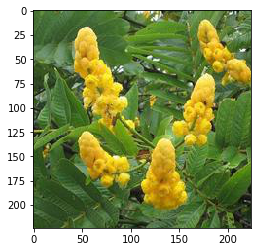

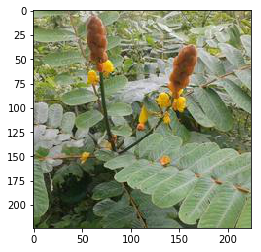

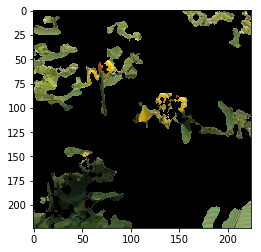

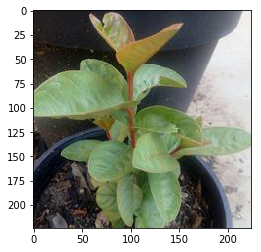

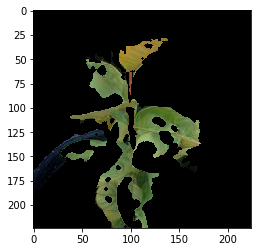

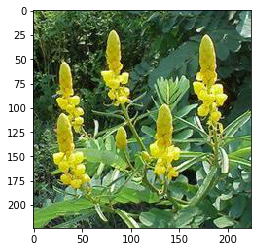

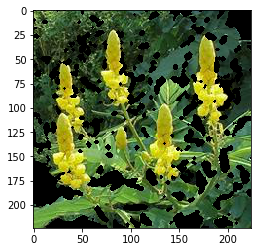

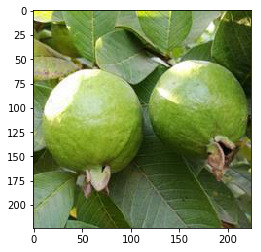

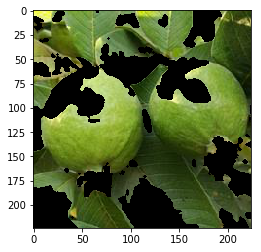

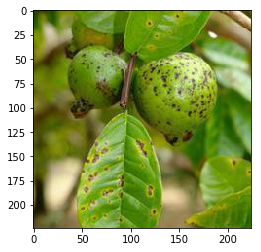

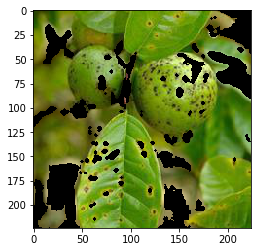

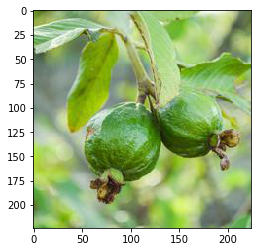

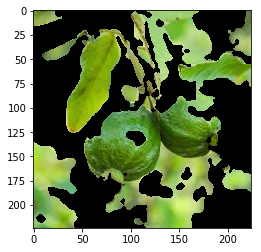

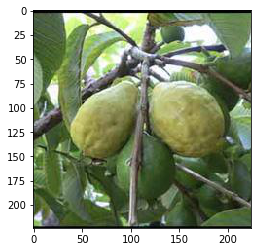

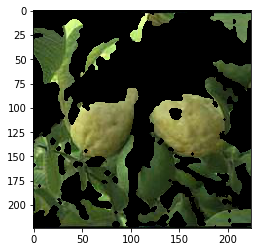

8 8


In [5]:
all_images, all_labels = extract_input_details(EVAL_DIR)
print(len(all_images), len(all_labels))

In [6]:
num_classes = len(CLASSES)

In [7]:
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    images = all_images
    labels = all_labels
    
    # Create the model:
    logits, end_points = resnet_v2.resnet_v2_50(images, num_classes=num_classes, is_training=False)
    logits = tf.reshape(logits, [len(images), num_classes])

    # Specify the loss function:
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels)
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(MODEL_DIR)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=MODEL_DIR,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values()))

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))
        
    probabilities = tf.nn.softmax(logits)
    init_fn = slim.assign_from_checkpoint_fn(checkpoint_path, slim.get_model_variables('resnet_v2_50'))

    sess = tf.Session()
    init_fn(sess)
    
    l = sess.run(logits)
    probs = sess.run(probabilities)
    print(logits)
    print(probs)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2018-05-02-00:10:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:/Users/Gio/Documents/projects/resnet50/model\model.ckpt-19412
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-05-02-00:10:41
eval/Accuracy: 0.500000
INFO:tensorflow:Restoring parameters from C:/Users/Gio/Documents/projects/resnet50/model\model.ckpt-19412
Tensor("Reshape:0", shape=(8, 2), dtype=float32)
[[4.8769242e-01 5.1230764e-01]
 [7.3987049e-01 2.6012951e-01]
 [5.8803964e-01 4.1196036e-01]
 [1.0000000e+00 7.3110152e-18]
 [9.3148702e-01 6.8512924e-02]
 [9.9324340e-01 6.7566279e-03]
 [6.3052692e-0